In [2]:
from transpile_benchy.interface import QASMBench, RedQueen
from transpile_benchy.interface import MQTBench

mqt = MQTBench(num_qubits=4, filter_str="hhl")
qasm_bench_s = QASMBench(size="small")
qasm_bench_m = QASMBench(size="medium")
# redqueen = RedQueen()

from transpile_benchy.metrics import DepthMetric
from qiskit.circuit.library import iSwapGate

depth_metric = DepthMetric(basis_gate=iSwapGate().power(1 / 2))

from qiskit.transpiler import CouplingMap

coupling_map = CouplingMap.from_grid(6, 6)
# coupling_map = CouplingMap.from_grid(4,4)
# coupling_map = CouplingMap.from_heavy_hex(5)

from virtual_swap.pass_managers import SabreVS, SabreQiskit  # , QiskitLevel3

Considering xx_plus_yy;	Cost 1 and Euclidean volume   0.00%
Considering xx_plus_yy·xx_plus_yy;	Cost 2 and Euclidean volume  50.00%
Considering xx_plus_yy·xx_plus_yy·xx_plus_yy;	Cost 3 and Euclidean volume 100.00%
Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 1.00	 | xx_plus_yy
 50.00% =    1/2    	 | 2.00	 | xx_plus_yy.xx_plus_yy
100.00% =    1/1    	 | 3.00	 | xx_plus_yy.xx_plus_yy.xx_plus_yy


/home/evm9/virtual-swap/src/virtual_swap/deprecated/__init__.py:3: UserWarning: The package you are importing is deprecated, is not maintained, and may not work as expected.
  warnings.warn(


In [3]:
from transpile_benchy.interface import QiskitFunctionInterface
from qiskit.circuit.library import TwoLocal

entanglement_types = ["linear", "full", "circular", "sca"]
entanglement_types = ["full", "reverse_linear"]


def function_generator(entanglement_type):
    def entanglement_function(n_qubits):
        return TwoLocal(n_qubits, ["ry"], "cx", entanglement_type, reps=1)

    entanglement_function.__name__ = f"TwoLocal_{entanglement_type}"
    return entanglement_function


num_qubits_options = [4, 8]

qiskit_functions_twolocal = [
    QiskitFunctionInterface(function_generator(entanglement_type), num_qubits_options)
    for entanglement_type in entanglement_types
]

In [4]:
# 5Q backend = provider.backend.ibmq_quito
# 20Q backend = provider.backend.ibmq_mumbai
from typing import Callable, List
from transpile_benchy.interface import QiskitFunctionInterface

num_qubits = [4, 8, 12, 16]  # , 20, 24, 28, 32, 36]
from qiskit.circuit.library import QFT, QuantumVolume

qiskit_functions_qft = QiskitFunctionInterface(QFT, num_qubits)
qiskit_functions_qv = QiskitFunctionInterface(QuantumVolume, num_qubits)

In [5]:
# next(MQTBench(num_qubits=4, filter_str="qaoa").get_quantum_circuits()).draw('mpl', fold=-1)

In [6]:
qasm_bench_m

In [ ]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

benchmark = Benchmark(
    transpilers=[
        SabreQiskit(coupling_map),  # , csx_basis=True),
        SabreVS(coupling_map, logger=transpile_benchy_logger)  # , cx_basis=True),
        # QiskitLevel3(coupling_map),
    ],
    # submodules=qiskit_functions_twolocal,
    submodules=[qasm_bench_m],
    # submodules=[qiskit_functions_qv],
    # submodules=[mqt],
    # submodules=[
    # MQTBench(num_qubits=4, filter_str="qaoa"),
    # MQTBench(num_qubits=8, filter_str="qaoa"),
    # MQTBench(num_qubits=12, filter_str="qaoa"),
    # MQTBench(num_qubits=16, filter_str="qaoa"),
    # ],
    metrics=[depth_metric],
    logger=transpile_benchy_logger,
    num_runs=3,  # 5
)
benchmark.run()

In [13]:
print(benchmark.results)

Metric: monodromy_depth, Circuit: multiplier_n15, Transpiler: SabreQiskit
  Best result: 345
  Worst result: 398
  Average result: 376.33
  Standard error: 27.79
Metric: monodromy_depth, Circuit: multiplier_n15, Transpiler: SabreVS
  Best result: 312
  Worst result: 353
  Average result: 333.00
  Standard error: 20.52
Metric: monodromy_depth, Circuit: wstate_n27, Transpiler: SabreQiskit
  Best result: 68
  Worst result: 82
  Average result: 74.33
  Standard error: 7.09
Metric: monodromy_depth, Circuit: wstate_n27, Transpiler: SabreVS
  Best result: 71
  Worst result: 91
  Average result: 79.00
  Standard error: 10.58
Metric: monodromy_depth, Circuit: cc_n12, Transpiler: SabreQiskit
  Best result: 33
  Worst result: 36
  Average result: 34.33
  Standard error: 1.53
Metric: monodromy_depth, Circuit: cc_n12, Transpiler: SabreVS
  Best result: None
  Worst result: None
  Average result: 0.00
  Standard error: 0.00
Metric: monodromy_depth, Circuit: bigadder_n18, Transpiler: SabreQiskit
  Be

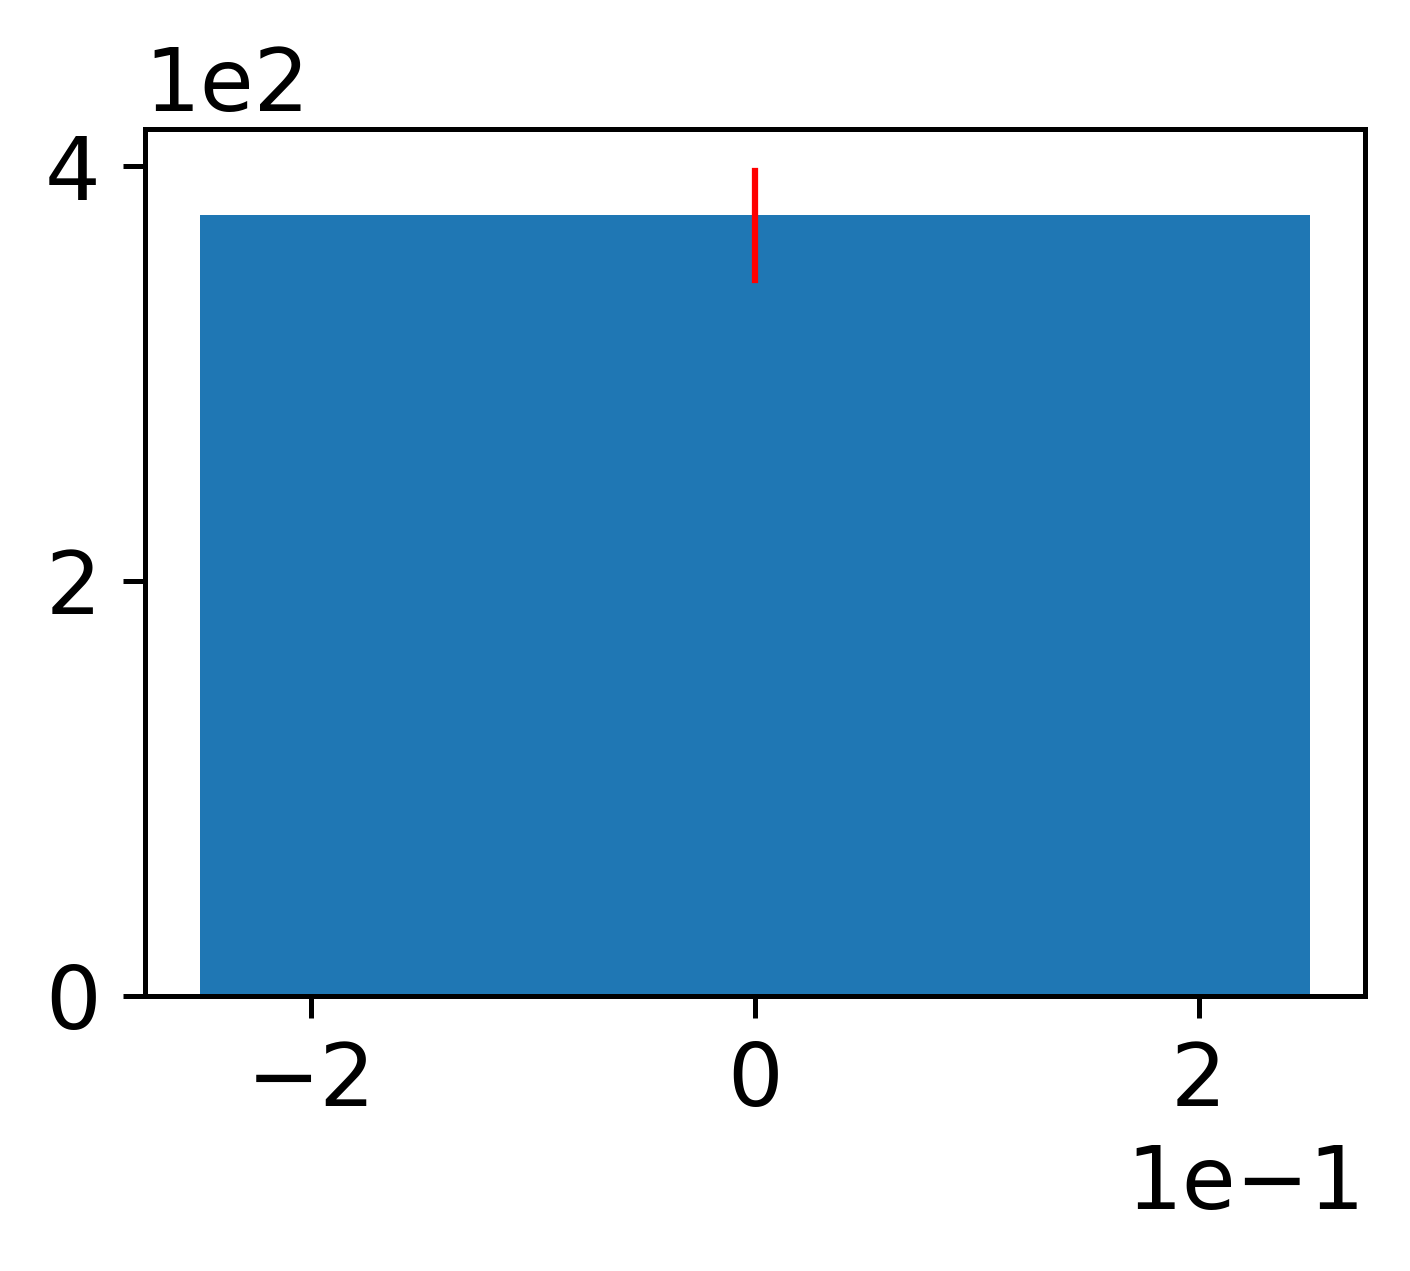

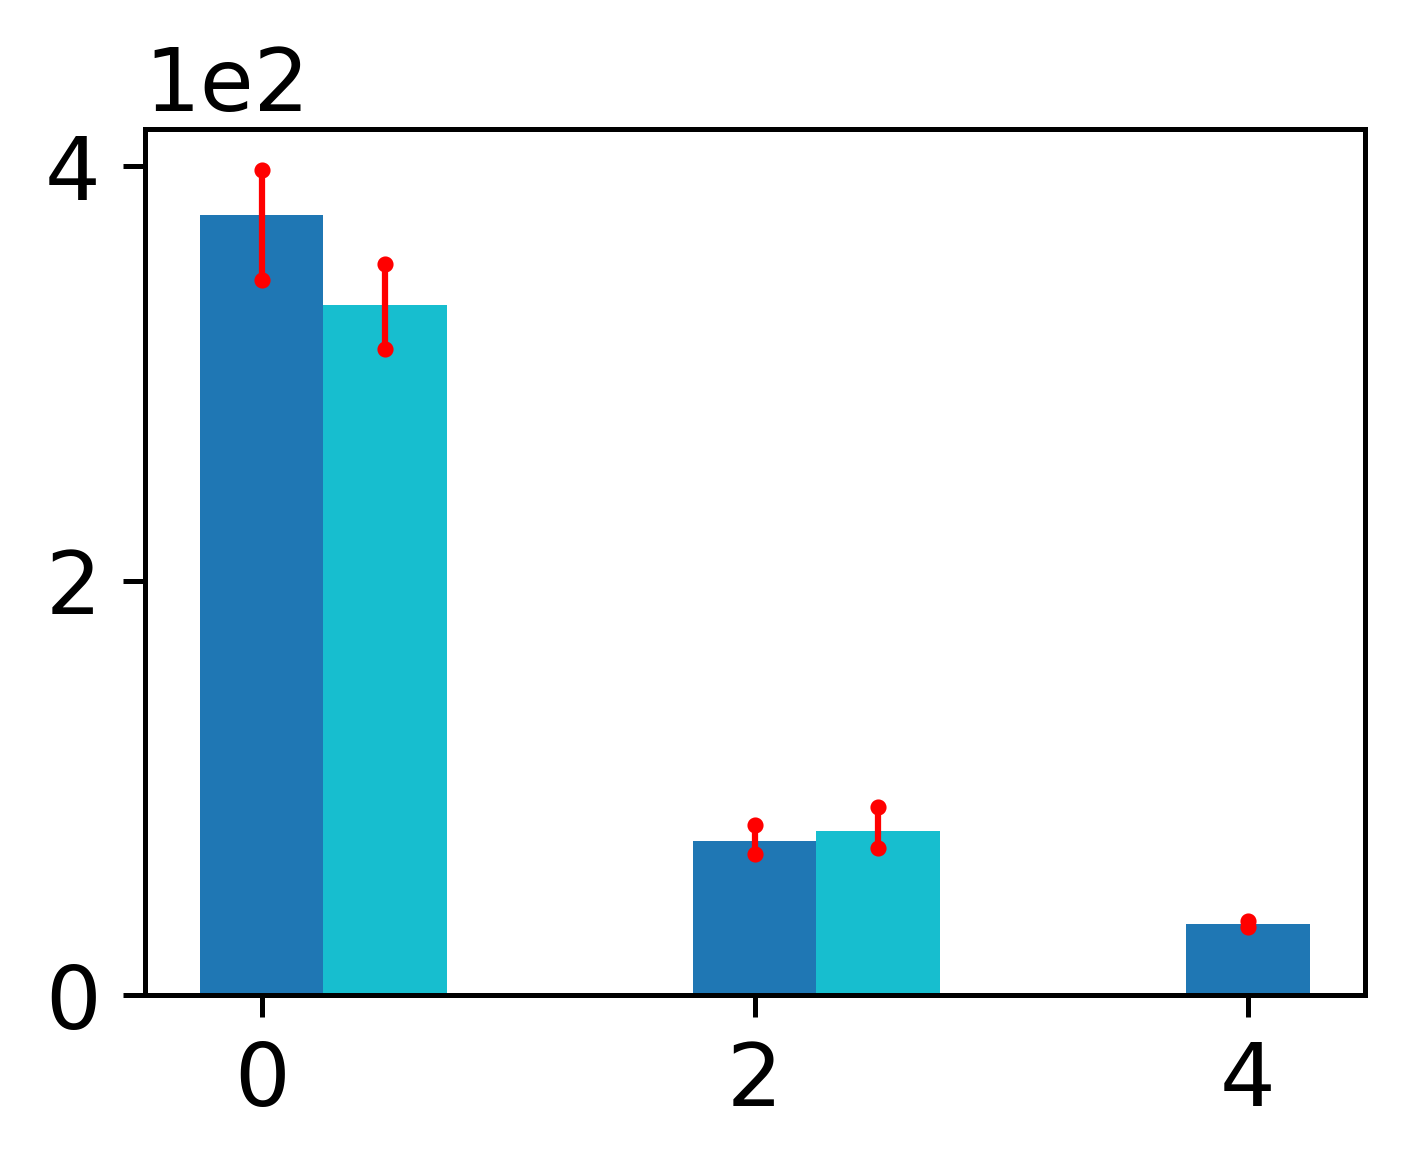

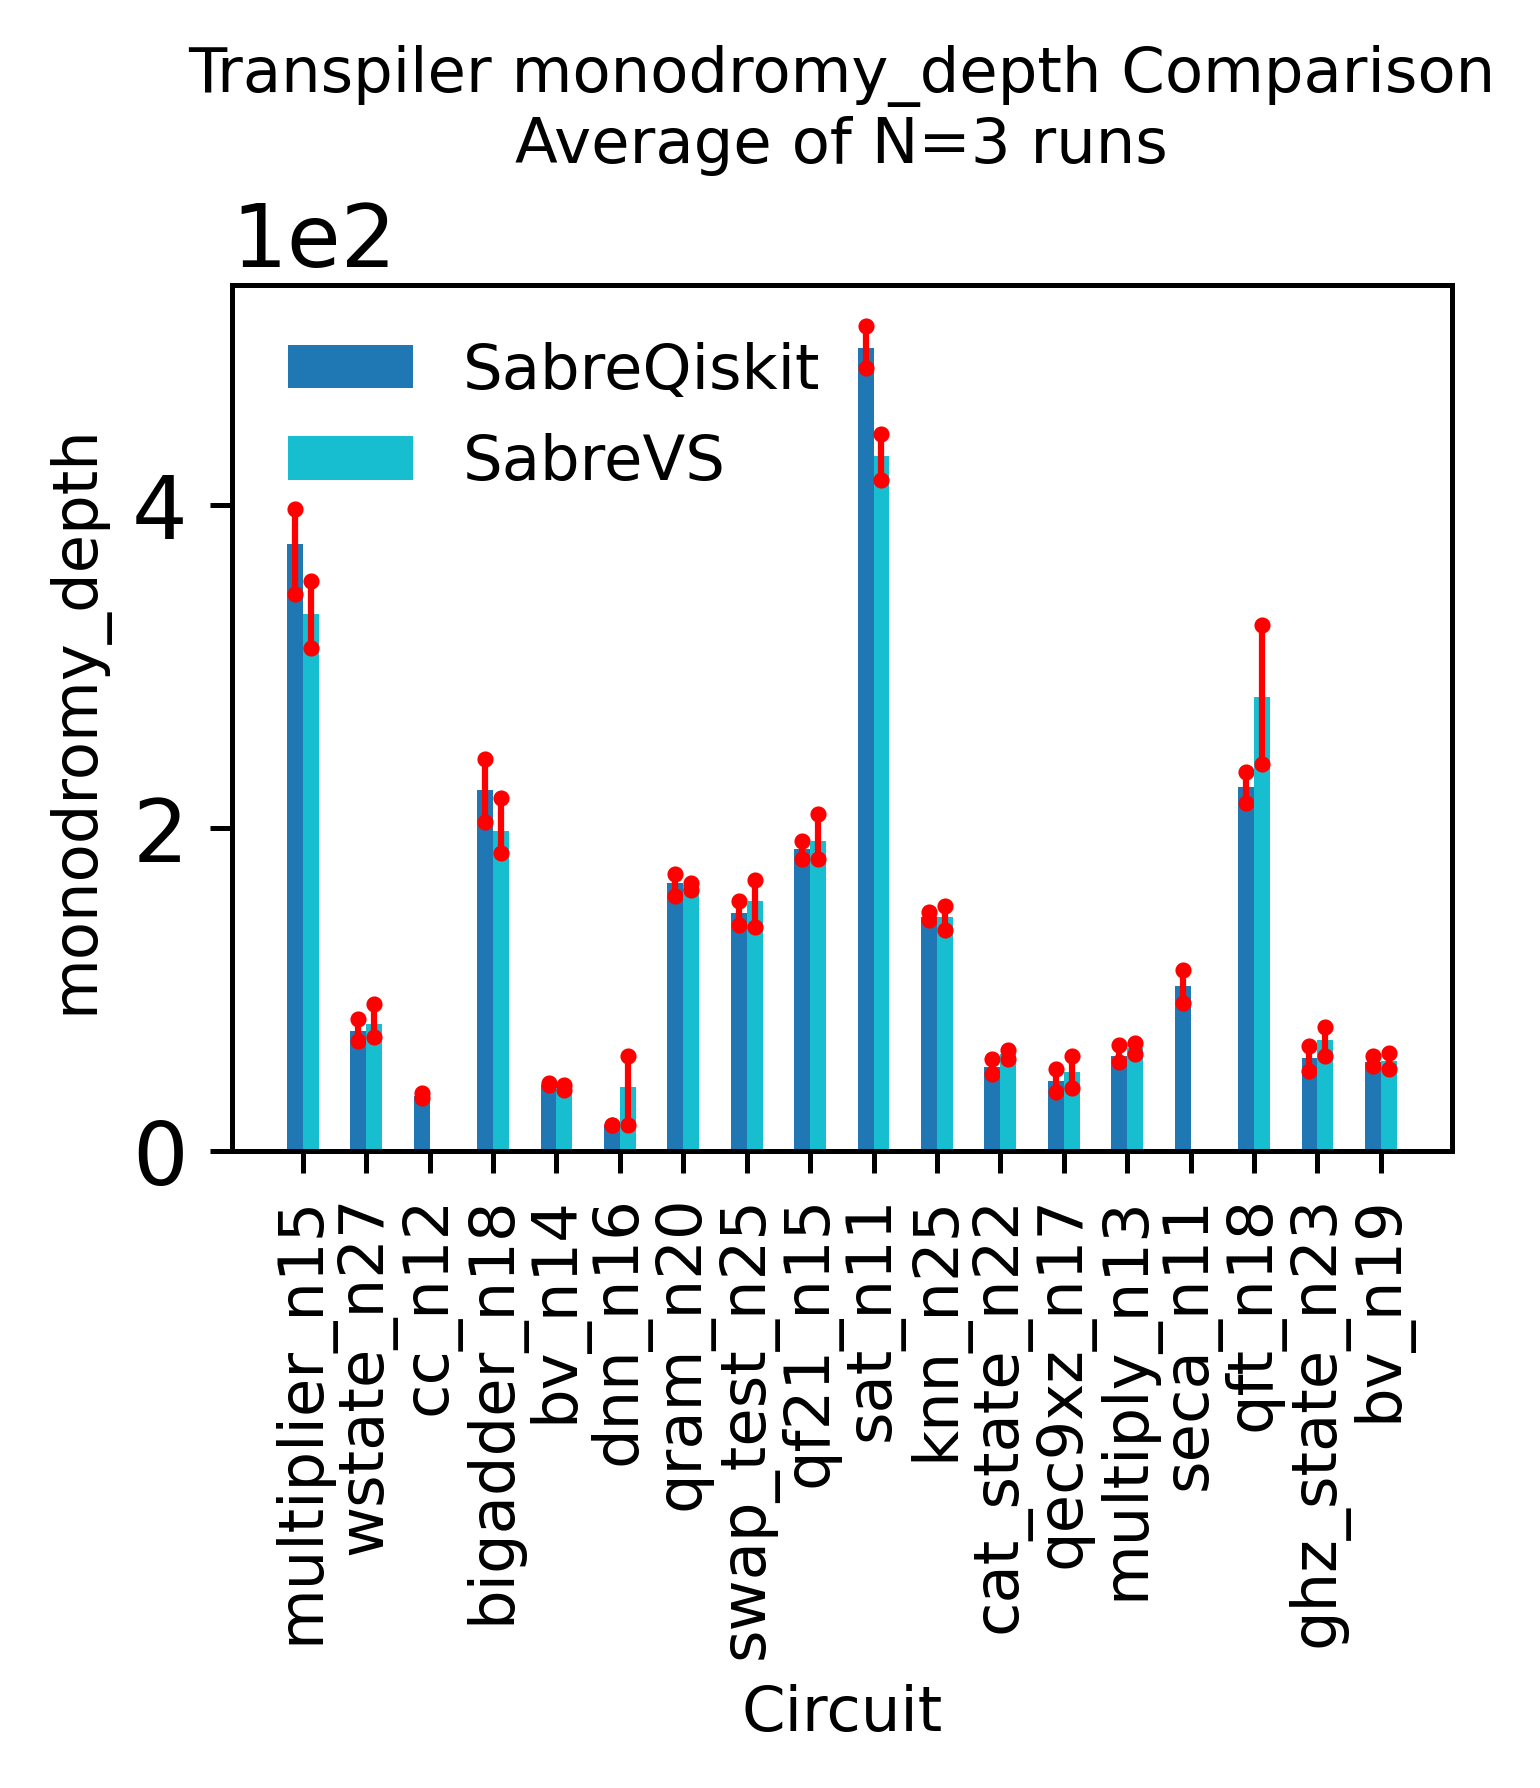

In [14]:
benchmark.plot()

### Below used for debugging indivudal circuit runs


In [ ]:
from qiskit.circuit.library import QuantumVolume, EfficientSU2, TwoLocal, QFT
from qiskit import QuantumCircuit

qc = EfficientSU2(8, entanglement="full", reps=2)
# qc = QFT(4)
# from qiskit import QuantumCircuit
# qc = QuantumCircuit(3)
# qc.ccx(0,1,2)
qc.decompose().draw("mpl")

In [ ]:
from qiskit.providers.fake_provider import FakeQuitoV2
from qiskit.transpiler.coupling import CouplingMap

coupling_map = FakeQuitoV2().target.build_coupling_map()
coupling_map = CouplingMap.from_line(4)
coupling_map = CouplingMap.from_grid(3, 3)
coupling_map.draw()

In [ ]:
# from qiskit.circuit.library import QFT

# # coupling_map = CouplingMap.from_line(5)
# coupling_map = CouplingMap.from_grid(5, 6)
# # qc = QFT(8)
# # qc = QuantumCircuit(8)
# # qc.h(0)
# # qc.cx(0, 1)
# # qc.cx(1, 2)
# # qc.cx(2, 3)
# # # qc.cx(3, 4)
# # qc.cx(4, 5)
# # qc.cx(5, 6)
# # qc.cx(6, 7)
# qc.decompose().draw(output="mpl")

In [ ]:
from virtual_swap.pass_managers import SabreVS, SabreQiskit
from transpile_benchy.metrics import DepthMetric

for _ in range(1):
    runner = SabreVS(coupling_map)  # , cx_basis=True)
    transp = runner.run(qc)
    # mid0 = runner.pm.property_set["mid0"]
    mid = runner.pm.property_set["circuit_progress"]
    # print(DepthMetric.calculate(transp))
    print(runner.pm.property_set["monodromy_depth"])
mid.draw(output="mpl", fold=-1)  # , filename="qft_vs.svg")
# transp.draw(output="mpl")

In [ ]:
# runner.pm.property_set["layout"]

In [ ]:
# set original qc to use
from qiskit import transpile

# qc2 = transpile(qc, initial_layout=runner.pm.property_set["layout"], coupling_map=coupling_map)
# qc2 = transpile(qc, coupling_map=coupling_map, optimization_level=3)
for _ in range(5):
    pm2 = SabreQiskit(coupling_map)  # , cx_basis=True)
    qc2 = pm2.run(qc)
    mid = pm2.pm.property_set["circuit_progress"]
    print(pm2.pm.property_set["monodromy_depth"])
mid.draw(output="mpl", fold=-1)  # , filename="qft_qiskit.svg")

In [ ]:
# qc2.draw(output="mpl")

In [ ]:
# from qiskit.quantum_info import Operator
# Operator(mid).equiv(qc2)